In [100]:
import pandas as pd
from tqdm import tqdm  
import numpy as np
import nltk
import copy
import pickle
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize

In [101]:
data = pd.read_csv("../../../data/processed_data/data_full_processed.csv", sep=",")

## Add Date

In [5]:
# xplore = pd.read_csv("../../../data/filtered/xplore.csv")
# acm = pd.read_csv("../../../data/filtered/filtered_acm_data.csv")
# science_direct = pd.read_csv("../../../data/filtered/science_direct_filtered_data.csv")

In [26]:
# # join data with the xplore, acm and science direct data as left join
# data = data.join(xplore.set_index("title"), on="title", how="left", rsuffix="_xplore")
# data = data.join(acm.set_index("title"), on="title", how="left", rsuffix="_acm")
# data = data.join(science_direct.set_index("title"), on="title", how="left", rsuffix="_science_direct")

,title,abstract,processed_abstract,date,link,abstract_xplore,datum,link_acm,abstract_acm,Unnamed: 0,abstract_science_direct,month,year
0,Investigating the Energy Production through Su...,Artificial Intelligence (AI) has the potential...,potential predict generation solar wind source...,NaN,https://ieeexplore.ieee.org/document/10136677/,Artificial Intelligence (AI) has the potential...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sustainability Is Not Enough: Towards AI Suppo...,"Sustainability, to describe it in simpler word...",describe simpler words bad limits destruction ...,NaN,https://ieeexplore.ieee.org/document/9198554/,"Sustainability, to describe it in simpler word...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AI Legitimacy for Sustainability,Sustainability is a vast subject involving var...,vast subject involving research possibilities ...,NaN,https://ieeexplore.ieee.org/document/9467431/,Sustainability is a vast subject involving var...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Keynote: AI for Scientific Discovery and a Sus...,Artificial Intelligence (AI) is a rapidly adva...,advancing reasoning reach new milestones world...,NaN,https://ieeexplore.ieee.org/document/10099237/,Artificial Intelligence (AI) is a rapidly adva...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Explainable AI for predicting daily household ...,"In the recent era, for most sustainable smart ...",point consideration urbanization carried expon...,NaN,https://ieeexplore.ieee.org/document/10060217/,"In the recent era, for most sustainable smart ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,Accelerating mitigation of climate change with...,"Integrated approaches across energy, water and...",water systems climate scientific advances oppo...,NaN,NaN,NaN,NaN,NaN,NaN,27.0,"Integrated approaches across energy, water and...",October,2021.0
359,Reinforcement learning in sustainable energy a...,The dynamic nature of sustainable energy and e...,dynamic electric systems environment change un...,NaN,NaN,NaN,NaN,NaN,NaN,28.0,The dynamic nature of sustainable energy and e...,NaN,2020.0
360,Fog computing for sustainable smart cities in ...,"In recent decade, the number of devices involv...",decade devices involved iot phenomena dramatic...,NaN,NaN,NaN,NaN,NaN,NaN,29.0,"In recent decade, the number of devices involv...",August,2020.0
361,Application of Artificial Intelligence to an E...,The evolution of artificial intelligence (AI) ...,resulted potential realization tremendous acce...,NaN,NaN,NaN,NaN,NaN,NaN,30.0,The evolution of artificial intelligence (AI) ...,NaN,2020.0


## Tokenization & Filtering

In [102]:
# new column with tokenized abstract
data["tokenized_abstract"] = data["processed_abstract"].apply(word_tokenize)
tokens = data["tokenized_abstract"].tolist()

# pos tagging to the tokenized words
pos_tagged_tokens = []
for token in tqdm(tokens):
    pos_tagged_tokens.append(nltk.pos_tag(token))

# keep only the nouns, verbs and adjectives
nouns_verbs = []
for pos_tagged_token in tqdm(pos_tagged_tokens):
    nouns_verbs.append([token[0] for token in pos_tagged_token if token[1] in ["NN", "NNS", "NNP", "NNPS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "JJ", "JJR", "JJS"]])

# remove tokens that are less than 2 characters
tokens = [[token for token in noun if len(token) > 2] for noun in nouns_verbs]

100%|██████████| 363/363 [00:00<00:00, 64101.23it/s]


## Bigrams

In [103]:
bigram_measures = nltk.collocations.BigramAssocMeasures() 
finder = BigramCollocationFinder.from_documents(tokens) 

# only bigrams that appear 5+ times (after several trials, 5 was the best number)
finder.apply_freq_filter(5) 

# return the 100 bigrams with the highest PMI
mwt = finder.nbest(bigram_measures.dice, 100) 

# remove tuples that contain: ('artificial', 'intelligence'), ('machine', 'learning'), ('deep', 'learning')
mwt = [t for t in mwt if t not in [('artificial', 'intelligence'), ('machine', 'learning'), ('deep', 'learning')]]

In [104]:
def collapse_tokens(token_list, mwt):
    '''
        This function takes a list of tokens and collapses the multi-word tokens (MWTs) into a single token.
    
        Parameters:
            token_list (list): A list of tokens
            mwt (list): A list of multi-word tokens

        Returns:
            res_token (list): A list of tokens with MWTs collapsed
    '''
    token_list = copy.copy(token_list)
    res_token = []
    while(len(token_list)>1):
        if (token_list[0],token_list[1]) in mwt:
            res_token.append(f'{token_list.pop(0)}_{token_list.pop(0)}')
        else:
            res_token.append(token_list.pop(0))
    
    if len(token_list) == 1:
        res_token.append(token_list.pop(0))

    return res_token

In [105]:
coll_tokens = [collapse_tokens(token_list, mwt) for token_list in tqdm(tokens)]

100%|██████████| 363/363 [00:00<00:00, 6600.36it/s]


In [106]:
def cv_token_return(doc):
    return doc

In [107]:
wordvect = CountVectorizer(analyzer="word", strip_accents='ascii',preprocessor=cv_token_return, tokenizer=cv_token_return, min_df=3)#, max_df=0.98) # create a word vectorizer object
dtm = wordvect.fit_transform(coll_tokens) # create a document term matrix

/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [108]:
data = zip(wordvect.get_feature_names_out(),
    np.asarray(dtm.sum(axis=0)).ravel())

df = pd.DataFrame(data, columns =['Word', 'Frequency'])
df.sort_values(by=['Frequency'], inplace=True, ascending=False)
print(df)

             Word  Frequency
169          data        125
745        system        124
143   consumption         97
410           iot         93
563         power         92
..            ...        ...
505     numerical          3
681       serving          3
274  experiencing          3
683         setup          3
529          pace          3

[842 rows x 2 columns]


## DTM

In [109]:
vocab = df.Word.to_list()[20:] # ignore the top 20 words

wordvect = CountVectorizer(vocabulary = vocab, analyzer="word", strip_accents='ascii',preprocessor=cv_token_return, tokenizer=cv_token_return, min_df=3, stop_words="english", max_df=0.98)
dtm = wordvect.fit_transform(coll_tokens)

/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


## LDA

In [114]:
for i in range(10):
    lda_model = LatentDirichletAllocation(n_components=8,               # Number of topics
                                        max_iter=250, # Max learning iterations
                                        learning_method='batch',   
                                        random_state=100+i, # Random state
                                        batch_size=128,  # n docs in each learning iter
                                        evaluate_every = 10, # compute perplexity every n iters, default: Don't
                                        n_jobs = -1, # Use all available CPUs
                                        )

    lda_output = lda_model.fit_transform(dtm)
    pickle.dump(lda_model, open(f"lda_model_{i}.pkl", "wb"))
    pickle.dump(lda_output, open(f"lda_output_{i}.pkl", "wb"))

# lda_output # document-topic matrix (document x topic)
# lda_model.components_ # topic-term matrix (topic x term) 

In [115]:
# obj0, obj1, obj2 are created here...
pickle.dump(wordvect, open("wordvect.pickel", "wb"))
pickle.dump(dtm, open("dtm.pickel", "wb"))

## Topics

In [116]:
def show_topics(vectorizer=wordvect, lda_model=lda_model, n_words=14):
    ''' 
        This function returns the top n keywords for each topic in a dataframe.

        Parameters:
            vectorizer (CountVectorizer): A CountVectorizer object
            lda_model (LatentDirichletAllocation): A LatentDirichletAllocation object
            n_words (int): The number of keywords to return for each topic

        Returns:
            topic_keywords (list): A list of the top n keywords for each topic
    '''
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [117]:
topic_keywords = show_topics(vectorizer=wordvect, lda_model=lda_model, n_words=15)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,buildings,applications,production,communication,approach,wireless,tools,mobile,home,services,industry,user,used,device,smart_home
Topic 1,smart_cities,cloud,electricity,resource,life,internet,technologies,architecture,applications,computing,day,strategies,waste,production,economic
Topic 2,devices,building,monitoring,networks,sensor,applications,based,information,community,process,research,mec,techniques,communication,resources
Topic 3,green,optimal,various,software,potential,using,model,framework,computing,driving,environment,technologies,generation,study,sensing
Topic 4,new,forecasting,using,used,optimization,production,method,machine,solar_power,climate,future,digital,techniques,based,sources
Topic 5,demand,machine,smart_grid,electricity,deep,dsm,operation,performance,research,intelligent,tasks,error,networks,variables,engineering
Topic 6,equipment,detection,electric,deep,image,recognition,wind,method,sources,people,battery,power_consumption,distribution,vehicle,analysis
Topic 7,scheduling,network,model,value,materials,strategy,urban,process,values,processing,integrated,human,load,optimisation,features


## Visualisation

In [118]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

pyLDAvis.lda_model.prepare(lda_model, dtm, wordvect)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.015372  0.074499       1        1  16.253782
2     -0.044813  0.200091       2        1  14.575152
4     -0.039319  0.061867       3        1  13.936747
1      0.107653 -0.004221       4        1  13.641916
7      0.148685 -0.082272       5        1  11.809415
3     -0.220504 -0.107299       6        1  11.181794
5      0.040061 -0.036796       7        1  10.913530
6     -0.007135 -0.105869       8        1   7.687665, topic_info=              Term       Freq      Total Category  logprob  loglift
0            green  47.000000  47.000000  Default  30.0000  30.0000
7              new  37.000000  37.000000  Default  29.0000  29.0000
9       scheduling  36.000000  36.000000  Default  28.0000  28.0000
16    smart_cities  33.000000  33.000000  Default  27.0000  27.0000
14         devices  35.000000  35.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
98     computation   3.567640  15.166875   Topic8  -5.0625   1.1183
111           cost   3.567602  14.242996   Topic8  -5.0626   1.1812
85          impact   3.567584  16.079047   Topic8  -5.0626   1.0599
114         health   3.567568  14.286985   Topic8  -5.0626   1.1781
44   manufacturing   3.567552  23.335720   Topic8  -5.0626   0.6874

[444 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
618       7  0.897725                 ability
654       3  0.669411            accelerating
654       8  0.223137            accelerating
655       3  0.665501                 adopted
655       6  0.221834                 adopted
...     ...       ...                     ...
58        2  0.144190                wireless
58        5  0.096127                wireless
58        6  0.144190                wireless
58        8  0.048063                wireless
277       1  0.854221  wireless_communication

[995 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 8, 4, 6, 7])

## Wordclouds

Topic#  1
scheduling,electricity,networks,load,strategy,regression,equipment,demand,resources,wireless,architecture,distribution,grid,source,studies,internet_things,classification,use,events,survey,home,blackouts,using,handling,end



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  2
data_data,review,climate,demand,forecasting,analytics,smart,operation,variables,wind_power,integrated,ecosystem,buildings,sources,model,optimization,vehicle,reliability,distribution,predictions,edge_computing,error,processes,battery,performance



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  3
enterprises,coal,used,industry,resources,platform,time,efficiency,gas,method,approach,number,solutions,recognition,cost,accuracy,compared,value,comfort,operation,datasets,feature,vehicles,parameters,business



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  4
detection,efficiency,generation,challenges,sensor,value,building,cities,grid,manufacturing,study,values,framework,environment,sources,countries,electricity,sensing,platform,fault,concept,grids,involving,review,wind



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  5
monitoring,countries,sources,performance,vehicle,fashion,using,based,world,technologies,protection,smart,intelligent,electricity,industry,device,sensor,system_system,construction,infrastructure,supply,innovation,university,gas,processes



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  6
models,approach,using,forecasting,grid,monitoring,concepts,lighting,based,user,analysis,duration,case,building,engineering,factors,plants,inference,networks,demand,environment,solutions,scenario,radiation,service



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  7
research,model,technologies,blockchain,process,materials,solutions,strategies,themes,policy,optimisation,maintenance,students,advances,grid,used,analysis,center,stage,emerging,generation,estimate,using,participants,optimization



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  8
cities,quality,life,using,detection,manufacturing,image,city,software,smart,health,crop,use,irrigation,error,costs,region,simulation,tracking,recognition,improving,gas,technologies,model,processing



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  9
techniques,waste,demand,resource,building,framework,optimization,results,model,scheduling,temperature,step,networks,solution,dsm,wind,approach,buildings,heating,cloud,methods,analysis,cooling,sensor,secure



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  10
improve,computing,information,problems,operations,stability,techniques,scheduling,order,manufacturing,process,battery,model,flow,systems_systems,computation,protocol,vehicles,services,climate,software,models,drl,estimation,structure



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  11
materials,buildings,strategy,offloading,process,issues,intelligence,detection,method,driving,hydropower,reasoning,resources,sensing,intelligent,computing,methods,output,farmers,greenhouse,power_grid,photovoltaic,engineering,impact,demand



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  12
environment,computing,processing,architecture,buildings,tools,homes,scheduling,based,study,cloud,reinforcement,used,comfort,models,methods,impact,time,machine,response,routing,mec,analyzes,innovation,economy



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  13
machine,wind,panels,internet,economy,consumer,speed,framework,technologies,distributed_learning,surface,society,distributed,life,strategies,approaches,detection,learning_learning,knowledge,load,location,plant,device,turbine,farms



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  14
communication,city,home,intelligence,cities,tasks,platforms,architecture,computation,smart,services,carbon,networks,building,community,model,wireless,tool,propose,optimization,methods,vehicle,zero,problem,industry



/Users/pierreachkar/miniconda3/envs/cer_project/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


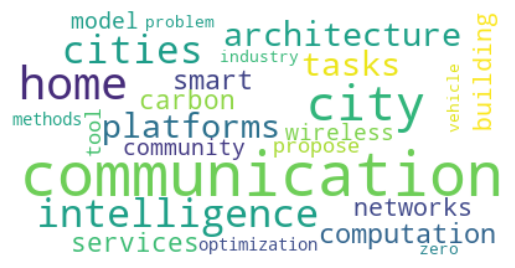

In [85]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

terms_count = 25
terms = wordvect.get_feature_names_out()

for idx,topic in enumerate(lda_model.components_):    
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}
    
    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]    
    wcloud = WordCloud(background_color="white",mask=None, max_words=100,\
                        max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                        contour_width=3,contour_color='black')
    wcloud.generate_from_frequencies(dict_word_frequency)       
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig("Topic#"+str(idx+1)+".png", format="png")

In [86]:
#Time series
topic_labels = []

for index, row in df_topic_keywords.iterrows():
    topic_labels.append('.'.join(row[0:5].to_list()))

print(topic_labels) # labels for each topic

['scheduling.electricity.networks.load.strategy', 'data_data.review.climate.demand.forecasting', 'enterprises.coal.used.industry.resources', 'detection.efficiency.generation.challenges.sensor', 'monitoring.countries.sources.performance.vehicle', 'models.approach.using.forecasting.grid', 'research.model.technologies.blockchain.process', 'cities.quality.life.using.detection', 'techniques.waste.demand.resource.building', 'improve.computing.information.problems.operations', 'materials.buildings.strategy.offloading.process', 'environment.computing.processing.architecture.buildings', 'machine.wind.panels.internet.economy', 'communication.city.home.intelligence.cities']


In [88]:
import random
data = pd.read_csv("../../../data/processed_data/data_full_processed.csv", sep=",")
my_sample = random.sample(range(1, len(data)), 3)

print(data.abstract[my_sample[0]] + "\n")
print(data.abstract[my_sample[1]] + "\n")
print(data.abstract[my_sample[2]] + "\n")

A neural network is a system with interconnected nodes called 'neurons,' which communicate an output by processing it through an activation function. It is based on the human brain, which means it trains itself to reduce errors. The objective of this project was to model efficient temperatures for nuclear fusion reactions to occur for maximum energy output. Nuclear fusion is a theoretical concept today but with the research done, a path to making it experimental can be paved. The neural network was developed through Anaconda Distribution and uses the software Spyder to code in Python. The source of the output is an activation function, which in this case was Te = (105)(Ip0.85)(P0.3)(ne0.61), where Te represents the temperature of the electrons. The actual output of the function is 4.19x10−5 eV to 4.19x10−4 eV and represents the value the neural network tried to predict. After being run for 1000 epochs, the loss function of the neural network was measured. The loss function measured how

In [89]:
vizDataFrame = pd.DataFrame({'Text_1': lda_output[my_sample[0],], 
                             'Text_2': lda_output[my_sample[1],],
                             'Text_3': lda_output[my_sample[2],]})

vizDataFrame.index = topic_labels

vizDataFrame

,Text_1,Text_2,Text_3
scheduling.electricity.networks.load.strategy,0.007143,0.005952,0.002304
data_data.review.climate.demand.forecasting,0.007143,0.005952,0.002304
enterprises.coal.used.industry.resources,0.007143,0.005952,0.002304
detection.efficiency.generation.challenges.sensor,0.007143,0.005952,0.002304
monitoring.countries.sources.performance.vehicle,0.007143,0.005952,0.002304
models.approach.using.forecasting.grid,0.007143,0.005952,0.002304
research.model.technologies.blockchain.process,0.007143,0.005952,0.970046
cities.quality.life.using.detection,0.007143,0.922619,0.002304
techniques.waste.demand.resource.building,0.007143,0.005952,0.002304
improve.computing.information.problems.operations,0.007143,0.005952,0.002304


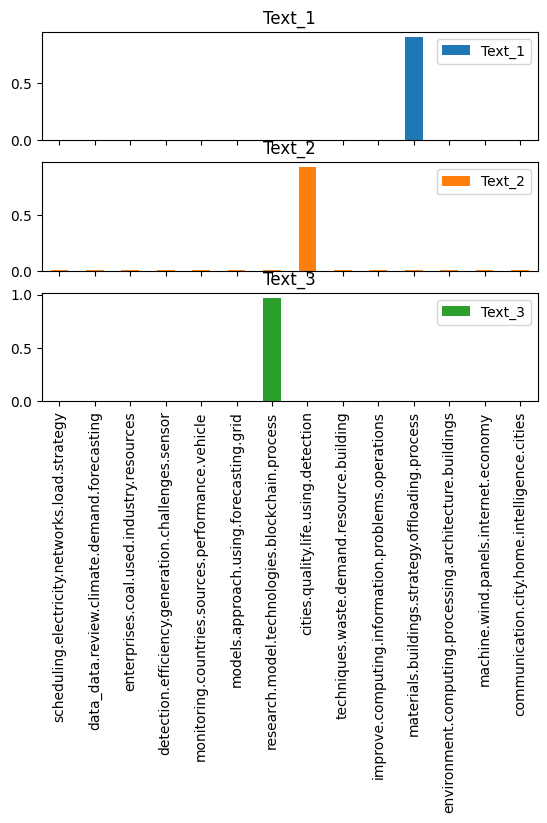

In [90]:
axes = vizDataFrame.plot.bar(rot=90, subplots=True)
axes[1].legend(loc=None) 

In [91]:
#Topic Importance
topicProportions = np.sum(lda_output, axis=0)/lda_output.shape[0]
topicProportions_df = pd.DataFrame({'Topic': topic_labels, 'Mean_Prob': topicProportions})
topicProportions_df.sort_values(by=['Mean_Prob'], inplace=True, ascending=False)
# Print the DataFrame
print(topicProportions_df)

                                                Topic  Mean_Prob
8           techniques.waste.demand.resource.building   0.081478
10    materials.buildings.strategy.offloading.process   0.081131
3   detection.efficiency.generation.challenges.sensor   0.080456
5              models.approach.using.forecasting.grid   0.079467
0       scheduling.electricity.networks.load.strategy   0.078034
12               machine.wind.panels.internet.economy   0.076320
13        communication.city.home.intelligence.cities   0.074149
9   improve.computing.information.problems.operations   0.073854
7                 cities.quality.life.using.detection   0.071134
11  environment.computing.processing.architecture....   0.064412
6      research.model.technologies.blockchain.process   0.063757
4    monitoring.countries.sources.performance.vehicle   0.062518
2            enterprises.coal.used.industry.resources   0.059071
1         data_data.review.climate.demand.forecasting   0.054219


In [92]:
#Rank-1 Method
num_topics = 8

countsOfPrimaryTopics = np.zeros(num_topics)

for row in lda_output:
    important_topic = (np.argsort(row)[::-1])[0]
    countsOfPrimaryTopics[important_topic] += 1

topicProportions_df_rank_1 = pd.DataFrame({'Topic': topic_labels, 'Count': countsOfPrimaryTopics})
topicProportions_df_rank_1.sort_values(by=['Count'], inplace=True, ascending=False)
# Print the DataFrame
print(topicProportions_df_rank_1)

IndexError: index 8 is out of bounds for axis 0 with size 8

In [93]:
#document distribution over time
import string
from matplotlib import cm

cmap = cm.get_cmap('Spectral')
data["decade"] = data.date.apply(lambda x: x.strip()[0:3] + "0")

# Combine the 2D array with the DataFrame column using Pandas' concat function
combined_array = pd.concat([pd.DataFrame(lda_output, columns=topic_labels), data["decade"]], axis=1)
aggregated_data = combined_array.groupby('decade').mean().reset_index()
aggregated_data.set_index('decade', inplace=True)

# Create a stacked bar chart
aggregated_data.plot.area(stacked=True,colormap=cmap, legend='reverse').legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',

)

# Optional: Customize the plot
import matplotlib.pyplot as plt

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Stacked Bar Chart')

plt.show()

/var/folders/xn/ds2yjvkj1yb_392m893dr1sm0000gn/T/ipykernel_37194/38329428.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral')


AttributeError: 'DataFrame' object has no attribute 'date'

In [94]:
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
# pip install tmtoolkit
# lda_model - LatentDirichletAllocation()
# vect - CountVectorizer()
# texts - the list of tokenized words
metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=lda_model.components_, 
                        dtm=dtm, 
                        vocab=np.array([x for x in wordvect.get_feature_names_out()]), 
                        texts=data.text.values)

AttributeError: 'DataFrame' object has no attribute 'text'